In [2]:
import pandas as pd
import os, sys
import numpy as np
import seaborn as sns
import gc
import warnings

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from gensim.models import Word2Vec

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
                          UpSampling1D, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, concatenate, \
                          Reshape, Dropout, BatchNormalization, GlobalAveragePooling1D, GlobalAveragePooling2D

from keras.utils import plot_model, to_categorical
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.utils.vis_utils import plot_model

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from custom_functions import norm_text, norm_brands, norm_images

pd.set_option('max_colwidth', 250)
warnings.filterwarnings(action='once')

In [3]:
main_dir = os.path.join(os.path.dirname(os.path.abspath('03_CandidateGeneration_20190422.ipynb')), 'custom_functions')
sys.path.insert(0, main_dir)
#sys.path

In [4]:
path = os.path.join('../../Data/')
path_text_encoders = os.path.join('../03_Preparacion_de_Datos/')
#EMbedding words = word2vec_model_v2
#Encoder = encoder_text_V1.h5

In [5]:
print (os.listdir(path_text_encoders))

['.ipynb_checkpoints', 'desktop.ini', 'encoder_text_V1.h5', 'encoder_text_V1.json', 'encoder_text_V2.h5', 'lda', 'lemmatization-es.txt', 'my_functions', 'PD_00_Preprocesado_20190309.ipynb', 'PD_01_GenerateCustomembedding_20190418.ipynb', 'PD_02_TextAutoencoder_20190418.ipynb', 'PD_98_LDA_Topics_0_20190313.ipynb', 'PD_99_Extra_20190421.ipynb', 'stopwords_catalan.txt', 'w2v_embedding_v1.h5', 'w2v_embedding_v1_1.h5', 'weights_encoder_text_V1.h5', 'word2vec_model_v1', 'word2vec_model_v2']


In [6]:
data = pd.read_csv(path + 'data_filtered_20190422.csv', sep = ';')
data_customers = pd.read_csv(path + 'customers_data_2.csv', sep = ';', nrows = 100000)
#data_text = pd.read_csv('Texto_PreProcesado_v2.csv', sep = ';')
#data_text = data_text[['item_id', 'text']]
data_customers.shape

(100000, 6)

In [7]:
data.head()

,item_id,availability_date,brand,category,name,price
0,A28233506,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo masculino con textura de mujer,"{'final': 199, 'currency': 'EUR'}"
1,A29054782,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo doble faz de mujer con cinturón a tono,"{'final': 149, 'currency': 'EUR'}"
2,A27354432,NaN,Woman El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo largo de antelina de mujer Woman El Corte Inglés,"{'final': 89.99, 'currency': 'EUR'}"
3,A28302706,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Chaqueta térmica de mujer Lloyds con efecto cortavientos,"{'final': 129, 'currency': 'EUR'}"
4,A27435502,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Parka 100% algodón de mujer Lloyds con capucha,"{'final': 149, 'currency': 'EUR'}"


In [8]:
data_customers.head()

,date,item_id,brand,PRICE,customer_id,text
0,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
1,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
2,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
3,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
4,20190101,A26870590,Fórmula Joven,"19,99",0,Vestido laminado de mujer Fórmula Joven con escote en pico


In [9]:
%%time
#7min
brands = norm_brands.launch_noramlizer(data_customers)
STOPWORDS_ALL =  norm_text.gen_stopwords(main_dir)
lemmatizer_inv = norm_text.get_lemmatizer(main_dir)
data_customers['text'] = data_customers.apply(lambda x: norm_text.normalize(words = x['text'], p_brands = brands,
                                                STOPWORDS_ALL = STOPWORDS_ALL, lemmatizer_inv = lemmatizer_inv),
                                             axis = 1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Enric\Google Drive\PROYECTOS\TFM_Motor de Recomendacion\Master\TFM_DNN_Recomendator\04_Modelado_y_Evaluacion\custom_functions\norm_text.py:20: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\Enric\\Google Drive\\PROYECTOS\\TFM_Motor de Recomendacion\\Master\\TFM_DNN_Recomendator\\04_Modelado_y_Evaluacion\\custom_functions\\stopwords_catalan.txt' mode='r' encoding='UTF-8'>
  STOPWORDS_CAT = open(path + '\stopwords_catalan.txt', 'r', encoding= 'UTF-8').read().split()


Wall time: 1min 16s


In [10]:
data_customers.columns = data_customers.columns.str.strip()
data_customers.PRICE = data_customers.PRICE.apply(lambda x: x.strip())
#data_customers.brand = data_customers.brand.apply(lambda x: x.strip())
data_customers.PRICE = data_customers.PRICE.str.replace('.', '')
data_customers.PRICE = data_customers.PRICE.str.replace(',', '.')
data_customers.PRICE = pd.to_numeric(data_customers['PRICE'])
data_customers.item_id = data_customers.item_id.apply(lambda x: x.strip())
data.item_id = data.item_id.apply(lambda x: x.strip())

In [11]:
data.columns = data.columns.str.strip()
#data['availability_date'].fillna(0, inplace=True)
data_customers['item_age'] = -1 * (data_customers['date'] - data['availability_date'])
data_customers['item_age'].fillna(0, inplace=True)

In [12]:
customers_unique = data_customers.customer_id.unique()
items_unique = data_customers.item_id.unique()
brand_unique = data_customers.brand.unique()

print (f'We have {len(customers_unique)} unique users and {len(items_unique)} unique items and {len(brand_unique)} unique brands')

We have 970 unique users and 30848 unique items and 1797 unique brands


### We need integer data to be able to feed the NN

In [13]:
customers_map = {i:val for i,val in enumerate(customers_unique)}
customers_map_inv = {val:i for i,val in enumerate(customers_unique)}

items_map = {i:val for i,val in enumerate(items_unique)}
items_map_inv = {val:i for i,val in enumerate(items_unique)}

brands_map = {i:val for i,val in enumerate(brand_unique)}
brands_map_inv = {val:i for i,val in enumerate(brand_unique)}

In [14]:
data_customers['customer_id_int'] = data_customers['customer_id'].map(customers_map_inv)
data_customers['item_id_int'] = data_customers['item_id'].map(items_map_inv)
data_customers['brand_id'] = data_customers['brand'].map(brands_map_inv)
data_customers.shape

(100000, 10)

In [15]:
data_score = data_customers.groupby(['customer_id_int', 'item_id_int']).size().to_frame('score').reset_index().sort_values(by = 'score',ascending = False)

In [16]:
data_final = pd.merge(data_customers, data_score, how = 'inner')
data_final.shape
#data_final = pd.merge(data_final, data_text, how = 'inner')
#data_final = data_customers

(100000, 11)

In [17]:
#remove duplicates due to agrupation, if a customer bought a item 2 times i only want 1 row with score 2, instead of 2 rows
data_final.drop_duplicates(inplace=True)
data_final.dropna(how = 'any', inplace = True)

print(data_final.shape)
data_final.head()

(53022, 11)


,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score
0,20190101,A26036172,tintoretto,27.99,0,vestido mujer flor lazada,0.0,0,0,0,8
4,20190115,A26036172,tintoretto,27.99,0,vestido mujer flor lazada,0.0,0,0,0,8
8,20190101,A26870590,fórmula joven,19.99,0,vestido laminado mujer formula joven escote pico,0.0,0,1,1,4
12,20190103,MP_0659870_3014,gabrielle,76.10,1,abrigo mujer negro avalorios,0.0,1,2,2,1
13,20190103,A26011856,antea plus,84.50,1,abrigo largo mujer talla grande plus cuello alto,0.0,1,3,3,1


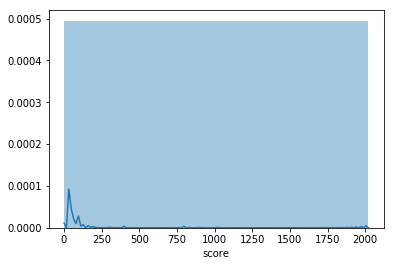

In [18]:
sns.distplot(data_score['score'], bins = 1);

## Vectorize sentences

In [19]:
MAX_NB_WORDS = 30_000 #decided by cumsum wordcount plot (Script 01)
MAX_SEQUENCE_LENGTH = 24 #decided by max words in a product (Script 00)
EMBEDDING_DIM = 100 #Same dim as our W2V embedding

all_text = data_final['text']
all_text = all_text.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_text)

data_sequences = tokenizer.texts_to_sequences(data_final['text'])
data_vec = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11327 unique tokens.


In [20]:
len(data_vec)

53022

In [21]:
data_final.shape

(53022, 11)

In [22]:
modelWV = Word2Vec.load(path_text_encoders + 'word2vec_model_v2')
encoder = load_model('encoder_text_V2.h5')

C:\Users\Enric\Anaconda3\lib\site-packages\gensim\utils.py:491: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  setattr(self, attrib, None)
C:\Users\Enric\Anaconda3\lib\site-packages\keras\engine\saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:
C:\Users\Enric\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [23]:
#lstm_emb = encoder.get_layer('ENCODER')
#encoder.summary()

In [24]:
word_vectors = modelWV.wv
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in modelWV:
        embedding_matrix[i] = modelWV[word]
    else:
        embedding_matrix[i] = np.random.rand(1, EMBEDDING_DIM)[0]
            

del(word_vectors)
gc.collect()

C:\Users\Enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\Enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


4

## Output

In [25]:
gc.enable()
del (data, data_score, data_customers, modelWV, embedding_matrix)
gc.collect()

28

In [26]:
CAT_ITEMS = len(items_unique)

In [27]:
#train_df, test_df = train_test_split(data_final, test_size=0.1, random_state = 12)
#print(f'{len(train_df)} train rows, {len(test_df)} validate rows')

In [28]:
#train_items_encoded = to_categorical(train_df['item_id_int'], num_classes = CAT_ITEMS)
#test_items_encoded = to_categorical(test_df['item_id_int'], num_classes = CAT_ITEMS)
items_encoded = to_categorical(data_final['item_id_int'], num_classes = CAT_ITEMS)
print(items_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [29]:
items_encoded.shape

(53022, 30848)

## Scale continuous data

In [30]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
data_to_scale = data_final[['PRICE','score', 'item_age']]
scaled_data = scaler.fit_transform(data_to_scale.values)

In [31]:
data_final['PRICE'] = scaled_data[:,0]
data_final['score'] = scaled_data[:,1]
data_final['item_age'] = scaled_data[:,2]

data_final['power_price'] = np.power(scaled_data[:,0], 2)
data_final['power_score'] = np.power(scaled_data[:,1], 2)
data_final['power_item_age'] = np.power(scaled_data[:,2], 2)

data_final['sqrt_price'] = np.sqrt(scaled_data[:,0])
data_final['sqrt_score'] = np.sqrt(scaled_data[:,1])
data_final['sqrt_item_age'] = np.sqrt(scaled_data[:,2])


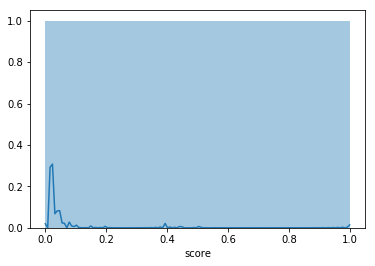

In [32]:
sns.distplot(data_final['score'], bins = 1);

## Architecture

In [33]:
#img_encoder = load_model('full_encoder_v1.h5')

In [34]:
data_final.head(3)
print(data_final.shape)

(53022, 17)


In [39]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
brand_id_input = Input(shape = [1], name = 'brand')

price_input = Input(shape = [1], name = 'price')
score_input = Input(shape = [1], name = 'score')
item_age_input = Input(shape = [1], name = 'item_age')

price_power_input = Input(shape = [1], name = 'power_price')
score_power_input = Input(shape = [1], name = 'power_score')
item_age_power_input = Input(shape = [1], name = 'power_item_age')

price_sqrt_input = Input(shape = [1], name = 'sqrt_price')
score_sqrt_input = Input(shape = [1], name = 'sqrt_score')
item_age_sqrt_input = Input(shape = [1], name = 'sqrt_item_age')

#text_input = Input(shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), name = 'text_input')

sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH, ), name = 'text')

embedding_size = 20

user_embedding = Embedding(output_dim=embedding_size, input_dim = customers_unique.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim = items_unique.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)
brand_embedding = Embedding(output_dim=embedding_size, input_dim = brand_unique.shape[0],
                           input_length=1, name='brand_embedding')(brand_id_input)

#text_embedding = Embedding(*embedding_matrix.shape, weights = [embedding_matrix], trainable = False)(sequence_input)

text_embedding = encoder([sequence_input])

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)
brand_vecs = Reshape([embedding_size])(brand_embedding)
text_flat = Flatten()(text_embedding)

x1 = concatenate([user_vecs, item_vecs, brand_vecs, price_input, item_age_input, score_input,
                 price_power_input, score_power_input, item_age_power_input,
                 price_sqrt_input, score_sqrt_input, item_age_sqrt_input, text_flat], name = 'VECTOR_PRODUCTO')

x2 = Dropout(0.4)(x1)
x3 = Dense (128, activation = 'relu')(x2)
x4 = Dropout(0.3)(x3)
x5 = Dense(64, activation = 'relu')(x4)
x6 = Dropout(0.2)(x5)
x7 = Dense(32, activation = 'relu')(x6)
x8 = Dropout(0.2)(x7)

output = Dense(CAT_ITEMS, activation = 'softmax' )(x8)

model = Model(inputs=[user_id_input, item_id_input, brand_id_input, price_input, sequence_input, item_age_input, score_input,
                     price_power_input, score_power_input, item_age_power_input,
                     price_sqrt_input, score_sqrt_input, item_age_sqrt_input], 
              outputs = output)

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
brand (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
text (InputLayer)               (None, 24)           0                                            
__________________________________________________________________________________________________
user_embed

In [40]:
def plot_training(history):
    plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [41]:
history = model.fit([data_final['customer_id_int'], data_final['item_id_int'], 
                     data_final['brand_id'], data_final['PRICE'],
                     data_vec, data_final['item_age'], data_final['score'],
                     data_final['power_price'], data_final['power_score'], data_final['power_item_age'],
                     data_final['sqrt_price'], data_final['sqrt_score'], data_final['sqrt_item_age']],
                     items_encoded,
                     epochs = 20, #validation_split = 0.1,
                     batch_size = 256, 
                     shuffle = True)

#Epoch 10 = loss = 7.8485 & acc = 0.0564
#Epoch 20 = loss = 5.4801 & acc = 0.1113

Epoch 1/20
53022/53022 [==============================] - 199s 4ms/step - loss: 10.1835 - acc: 0.0039
Epoch 2/20
53022/53022 [==============================] - 192s 4ms/step - loss: 9.6928 - acc: 0.0077
Epoch 3/20
53022/53022 [==============================] - 188s 4ms/step - loss: 9.3520 - acc: 0.0107
Epoch 4/20
53022/53022 [==============================] - 195s 4ms/step - loss: 9.0731 - acc: 0.0142
Epoch 5/20
53022/53022 [==============================] - 190s 4ms/step - loss: 8.8250 - acc: 0.0159
Epoch 6/20
53022/53022 [==============================] - 186s 4ms/step - loss: 8.6399 - acc: 0.0179
Epoch 7/20
53022/53022 [==============================] - 192s 4ms/step - loss: 8.5119 - acc: 0.0196
Epoch 8/20
53022/53022 [==============================] - 192s 4ms/step - loss: 8.4123 - acc: 0.0203
Epoch 9/20
53022/53022 [==============================] - 187s 4ms/step - loss: 8.3302 - acc: 0.0224
Epoch 10/20
53022/53022 [==============================] - 191s 4ms/step - loss: 8.2663 - 

In [42]:
model.save('candidate_generation_20190515')

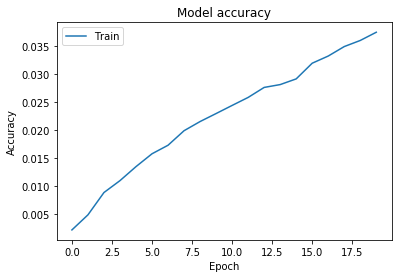

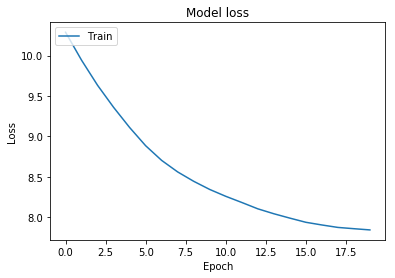

In [92]:
plot_training(history)

In [94]:
test_pred = model.predict([data_final['customer_id_int'], data_final['item_id_int'], 
                     data_final['brand_id'], data_final['PRICE'],
                     data_vec, data_final['item_age'], data_final['score'],
                     data_final['power_price'], data_final['power_score'], data_final['power_item_age'],
                     data_final['sqrt_price'], data_final['sqrt_score'], data_final['sqrt_item_age']],
                     verbose = 1)

53022/53022 [==============================] - 47s 889us/step


In [97]:
test_pred.shape

(53022, 30848)

In [98]:
test_pred[:10]

array([[2.1049020e-01, 3.5717363e-14, 9.5872518e-11, ..., 8.8759413e-16,
        1.4855447e-15, 2.0986493e-15],
       [2.1049020e-01, 3.5717363e-14, 9.5872518e-11, ..., 8.8759413e-16,
        1.4855447e-15, 2.0986493e-15],
       [5.2098767e-05, 6.7886841e-03, 8.1369939e-07, ..., 4.4830421e-07,
        6.8938272e-07, 1.9837235e-06],
       ...,
       [1.0897405e-03, 6.9561906e-06, 3.7430618e-06, ..., 2.9898140e-06,
        2.5252118e-06, 2.7388546e-06],
       [8.5883419e-04, 1.0962652e-04, 1.5484171e-05, ..., 3.5356973e-06,
        5.1931056e-06, 8.8499346e-06],
       [4.8554564e-04, 1.3044775e-04, 1.6224833e-05, ..., 5.8041801e-06,
        8.5223865e-06, 1.2361014e-05]], dtype=float32)

In [99]:
CUSTOMER = 101

In [100]:
top10 = test_pred[CUSTOMER].argsort()[-1000:][::-1] #items positions

In [103]:
items_unique[top10][:10]

array(['A12318252', 'A21084480', 'A27097687', 'A24811179', 'A26026701',
       'A24856869', 'A19199484', 'A24965927', 'A27097553', 'A27097623'],
      dtype=object)

In [104]:
data = pd.read_csv(path + 'data_filtered_20190422.csv', sep = ';')

In [105]:
data[data['item_id'].isin(items_unique[top10])]

,item_id,availability_date,brand,category,name,price
5,A28130802,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Gabardina 100% algodón repelente al agua de mujer,"{'final': 199, 'currency': 'EUR'}"
260,A27257835,NaN,Easy Wear,"['Moda', 'Mujer', 'Abrigos']",Chaqueta husky básica de mujer Easy Wear,"{'final': 59.99, 'currency': 'EUR'}"
1528,A26925999,NaN,Fórmula Joven,"['Moda', 'Mujer', 'Chaquetas y Blazers']",Kimono de mujer Fórmula Joven con terciopelo y flecos,"{'original': 59.99, 'final': 19.99, 'currency': 'EUR'}"
1529,A26926012,NaN,Fórmula Joven,"['Moda', 'Mujer', 'Chaquetas y Blazers']",Kimono de mujer Fórmula Joven con terciopelo y flecos,"{'original': 59.99, 'final': 19.99, 'currency': 'EUR'}"
1984,A28548893,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Pantalones']",Pantalón recto fluido de mujer,"{'final': 89.99, 'currency': 'EUR'}"
2126,A28372270,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Pantalones']",Pantalón fluido de mujer,"{'final': 49.99, 'currency': 'EUR'}"
2547,A26712352,NaN,GAP,"['Moda', 'Mujer', 'Sudaderas']",Sudadera de mujer Gap con logo y capucha,"{'original': 65.95, 'final': 26.38, 'currency': 'EUR'}"
3409,A27256042,NaN,Easy Wear,"['Moda', 'Mujer', 'Vestidos']",Pichi de rayas con dos bolsillos,"{'final': 25.99, 'currency': 'EUR'}"
3783,A27520202,NaN,Lloyd's,"['Moda', 'Mujer', 'Pantalones']",Pantalón pitillo cinco bolsillos de mujer,"{'final': 65.99, 'currency': 'EUR'}"
3798,A25578948,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Chaqueta larga guateada de mujer Lloyds,"{'original': 129, 'final': 38.7, 'currency': 'EUR'}"


In [106]:
data_final.loc[CUSTOMER]['customer_id_int']

18

In [107]:
data_final[data_final.customer_id_int == 101]

,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score,power_price,power_score,power_item_age,sqrt_price,sqrt_score,sqrt_item_age
1323,20190103,MP_0478263_30F8SV6T4L0001,michael kors,0.020334,101,bolso hombro voyager estilo tote piel grano cruzado,0.0,101,318,43,0.0,0.000413,0.0,0.0,0.142598,0.0,0.0
1324,20190103,MP_0478263_30F8GM9T3T0001,michael kors,0.027742,101,bolso hombro mercer tipo acordeon piel granulada,0.0,101,618,43,0.0,0.000770,0.0,0.0,0.166559,0.0,0.0
1325,20190103,MP_0478263_30H7GV6T8L0001,michael kors,0.024038,101,bolso hombro voyager estilo tote piel,0.0,101,383,43,0.0,0.000578,0.0,0.0,0.155042,0.0,0.0
4764,20190103,A27221472,tintoretto,0.012556,101,vestido mujer flor abalorio,0.0,101,694,0,0.0,0.000158,0.0,0.0,0.112054,0.0,0.0
4765,20190103,A27610463,fórmula joven,0.007370,101,vestido plisado flor,0.0,101,1158,1,0.0,0.000054,0.0,0.0,0.085848,0.0,0.0
4766,20190103,A27610471,fórmula joven,0.007370,101,vestido mujer formula joven flor volante,0.0,101,1159,1,0.0,0.000054,0.0,0.0,0.085848,0.0,0.0
4767,20190103,A27628203,fórmula joven,0.005888,101,vestido mujer formula joven flor estampado halter,0.0,101,1160,1,0.0,0.000035,0.0,0.0,0.076736,0.0,0.0


In [ ]:
del data
gc.collect()